In [9]:
import numpy as np
import matplotlib.pyplot as plt

import pygimli as pg
from pygimli.viewer.mpl import drawModel1D
import pandas as pd

import sys, os

# # Disable
# def blockPrint():
#     sys.stdout = open(os.devnull, 'w')

# # Restore
# def enablePrint():
#     sys.stdout = sys.__stdout__

In [10]:
df = pd.read_csv("cowsns.csv")
ab2 = df["AB/2 [m]"]
rhoa = df["R [rho]"]

In [19]:
# nlay = 20 # number of layers
# lam = 200.  # (initial) regularization parameter
errPerc = 3.  # relative error of 3 percent=
# ab2 = df["AB/2 [m]"]
# rhoa = df["R [rho]"]
# mn2 = ab2 / 3.  # MN/2 distance (potential electrodes)


def invert(nlay, ab2, mn2, lam, rhoa, mscheme=0.5):
    print(2*max(rhoa))
   
    f = pg.core.DC1dModelling(nlay, ab2, mn2)

    transThk = pg.trans.TransLog() 
    transRho = pg.trans.TransLogLU(1, 2*max(rhoa)) 
    transRhoa = pg.trans.TransLog() 

    f.region(0).setTransModel(transThk)  
    f.region(1).setTransModel(transRho)  

    paraDepth = max(ab2) / 3.  # rule-of-thumb for Wenner/Schlumberger
    f.region(0).setStartValue(paraDepth / nlay / 2)
    f.region(1).setStartValue(np.median(rhoa))

    inv = pg.core.Inversion(rhoa, f, transRhoa, True) 
    inv.setRelativeError(errPerc / 100.0)  
    inv.setLambda(lam) 
    inv.setMarquardtScheme(mscheme)
    #help(inv)
    print("starting lambda value:", inv.getLambda(), lam)
    model = f.createStartVector()  
    #model[nlay] *= 1.5
    inv.setModel(model)
    
    model = inv.run()
    
    res, thk = model[nlay-1:nlay*2-1], model[0:nlay-1]
    print('rrms={:.2f}%, chi^2={:.3f}'.format(inv.relrms(), inv.chi2()))

    fig, ax = plt.subplots(ncols=2, figsize=(8, 6))  # two-column figure
   
    drawModel1D(ax[0], thk, res, color='b', label=f"chi2 = {round(inv.chi2())}")
    ax[0].grid(True, which='both')
    ax[0].set_ylabel('z (m)')
    ax[0].set_xlabel(r'$\rho$ ($\Omega$m)')
    ax[0].legend(loc='best')
    #ax[0].set_ylim(max(ab2), 0)
  
    ax[1].loglog(np.array(rhoa).reshape(len(rhoa),1), np.array(ab2).reshape(len(ab2),1), 'rx-', label='measured')
    ax[1].loglog(np.array(inv.response()).reshape(len(inv.response()),1), ab2, 'b-', label='fitted')

    ax[1].set_ylim((max(ab2), min(ab2)))
    ax[1].grid(True, which='both')
    ax[1].set_xlabel(r'$\rho_a$ ($\Omega$m)')
    ax[1].set_ylabel('AB/2 (m)')
    ax[1].legend(loc='best')
    
    fig.suptitle(f"VES Inversion Best Fit with {nlay} Layers")
    plt.show()
    
    return model, inv.chi2()

#model, chi2 = invert(len(rhoa)+1, ab2, mn2, lam, rhoa, 0.4)

In [20]:
df

,AB/2 [m],R [rho]
0,1.0,888.285323
1,1.5,1143.539726
2,2.0,1353.633735
3,3.0,1621.847207
4,4.0,1608.102740
5,5.0,1611.849089
6,6.0,1306.187832
7,7.0,1101.167495
8,8.0,941.299699
9,9.0,816.861214


In [21]:
# Load the rest of the data

import csv

rows = []
with open('cowsjackpot.csv', newline='') as csvfile:
     spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
     for row in spamreader:
         rows.append(', '.join(row))

In [22]:
import io
colnames=["N", "a", "n", "ab2", "r", "rhoa", "sigma"] 
dcowsns = pd.read_csv(io.StringIO('\n'.join(rows[2:14])), names=colnames)
dcowses = pd.read_csv(io.StringIO('\n'.join(rows[18:30])), names=colnames)
mcowsns = pd.read_csv(io.StringIO('\n'.join(rows[34:47])), names=colnames)

djackns = pd.read_csv(io.StringIO('\n'.join(rows[51:64])), names=colnames)
mjackns = pd.read_csv(io.StringIO('\n'.join(rows[68:])), names=colnames)

In [23]:
# Try to find the best fit for each dataset seperately and then average the dipole for cows and repeat.
mjackns
np.zeros(ab2.shape) + 0.5
ab2

0      1.0
1      1.5
2      2.0
3      3.0
4      4.0
5      5.0
6      6.0
7      7.0
8      8.0
9      9.0
10    10.0
11    11.0
Name: ab2, dtype: float64

/opt/anaconda3/conda-bld/pgcore_1645178403028/work/gimli/core/src/regionManager.h:182		void GIMLI::Region::setStartValue(double)  is deprecated 
/opt/anaconda3/conda-bld/pgcore_1645178403028/work/gimli/core/src/regionManager.h:182		void GIMLI::Region::setStartValue(double)  is deprecated 
/opt/anaconda3/conda-bld/pgcore_1645178403028/work/gimli/core/src/modellingbase.cpp:523		GIMLI::RVector GIMLI::ModellingBase::createStartVector()  is deprecated 


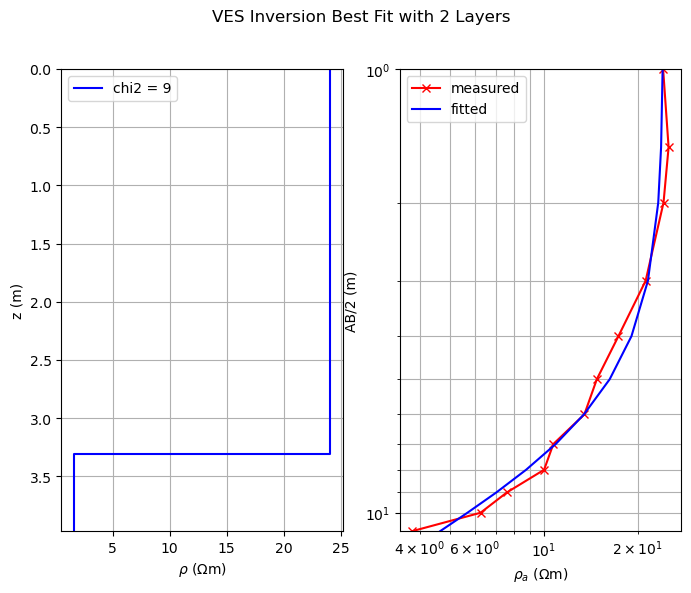

,Resistivity (Ohm*m),Conductivity (S/m),Thickness (m)
0,24.084605,0.041520,3.308451
1,1.627873,0.614299,inf


In [24]:
df2 = mjackns

print(ab2)
ab2 = df2["ab2"][:-1]
mn2 = np.zeros(ab2.shape) + 0.5
rhoa = df2["rhoa"][:-1]

nlay = 2

model, chi2 = invert(nlay, ab2, mn2, 200, rhoa, 0.9)
res, thk = model[nlay-1:nlay*2-1], list(model[0:nlay-1])
thk.append(np.inf)
layers = pd.DataFrame({"Resistivity (Ohm*m)": res, "Conductivity (S/m)": 1/res, "Thickness (m)": thk})
layers

In [48]:
n = df2["n"]
a = df2["a"]

In [49]:
mx = -a/2
my = 0

nx = a/2
ny = 0

ax = -(n+1/2)*a
ay = 0

bx = (n+1/2)*a
by = 0

In [50]:
k = 2*np.pi/(((ax-mx)**2 + (ay-my)**2)**-0.5 - ((bx-mx)**2 + (by-my)**2)**-0.5 - ((ax-nx)**2 + (ay-ny)**2)**-0.5 + ((bx-nx)**2 + (by-ny)**2)**-0.5)

In [28]:
AB2 = abs((ax-bx)/2)
MN2 = abs((mx-nx)/2)

/opt/anaconda3/conda-bld/pgcore_1645178403028/work/gimli/core/src/regionManager.h:182		void GIMLI::Region::setStartValue(double)  is deprecated 
/opt/anaconda3/conda-bld/pgcore_1645178403028/work/gimli/core/src/regionManager.h:182		void GIMLI::Region::setStartValue(double)  is deprecated 
/opt/anaconda3/conda-bld/pgcore_1645178403028/work/gimli/core/src/modellingbase.cpp:523		GIMLI::RVector GIMLI::ModellingBase::createStartVector()  is deprecated 


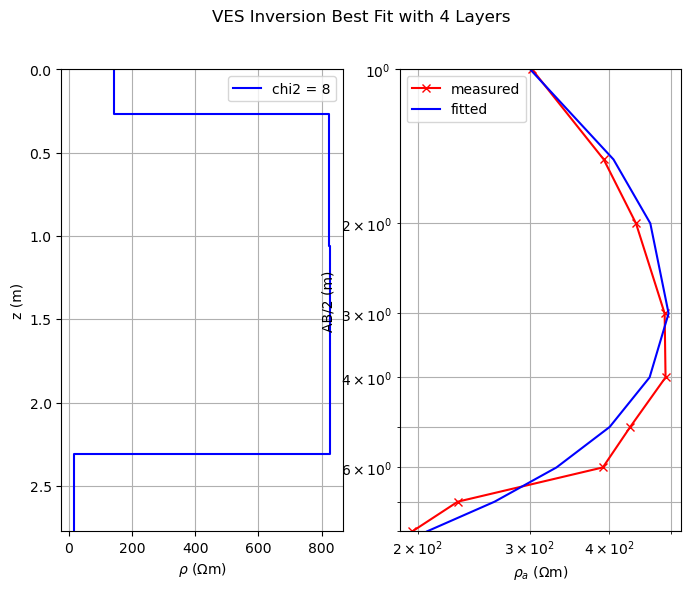

,Resistivity (Ohm*m),Conductivity (S/m),Thickness (m)
0,144.155795,0.006937,0.268788
1,823.648967,0.001214,0.793387
2,827.270927,0.001209,1.248039
3,17.907315,0.055843,inf


In [34]:
df2 = dcowsns
ab2 = df2["ab2"][:-3]
mn2 = np.zeros(ab2.shape) + 0.5
rhoa = df2["rhoa"][:-3]

nlay = 4

model, chi2 = invert(nlay, ab2, mn2, 200, rhoa, 0.9)
res, thk = model[nlay-1:nlay*2-1], list(model[0:nlay-1])
thk.append(np.inf)
layers = pd.DataFrame({"Resistivity (Ohm*m)": res, "Conductivity (S/m)": 1/res, "Thickness (m)": thk})
layers

In [35]:
dcowsns[:-2]

,N,a,n,ab2,r,rhoa,sigma
0,1,1,0.5,1.0,128.40,302.535372,0.003305
1,2,1,1.0,1.5,62.40,392.070763,0.002551
2,3,1,1.5,2.0,37.40,440.608370,0.002270
3,4,1,2.5,3.0,17.78,488.753277,0.002046
4,5,1,3.5,4.0,9.91,490.347635,0.002039
5,6,1,4.5,5.0,5.55,431.537021,0.002317
6,7,1,5.5,6.0,3.48,390.845542,0.002559
7,8,1,6.5,7.0,1.51,231.260489,0.004324
8,9,1,7.5,8.0,0.98,196.271001,0.005095
9,10,1,8.5,9.0,0.41,104.010279,0.009614


I want to see if I can fit one of the datasets for a resistance added in series.
I'm going to use scipy's curve_fit using n as the independent variable, apparent 
resistivity as the dependent variable, and the lead resistance an soil resistance as 
fitting parameters. I'm going to use one the datsets where I'm pretty sure that the soil fit best
with one layer accoridng to my initial fits and ian's results.

In [42]:
import pickle

with open(f"pickled_fit", 'rb') as file:
    popt = pickle.load(file)

/opt/anaconda3/conda-bld/pgcore_1645178403028/work/gimli/core/src/regionManager.h:182		void GIMLI::Region::setStartValue(double)  is deprecated 
/opt/anaconda3/conda-bld/pgcore_1645178403028/work/gimli/core/src/regionManager.h:182		void GIMLI::Region::setStartValue(double)  is deprecated 
/opt/anaconda3/conda-bld/pgcore_1645178403028/work/gimli/core/src/modellingbase.cpp:523		GIMLI::RVector GIMLI::ModellingBase::createStartVector()  is deprecated 


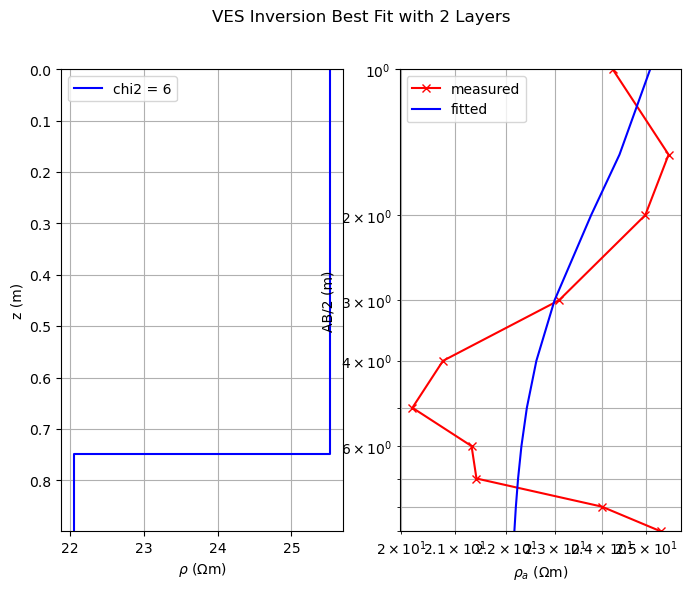

,Resistivity (Ohm*m),Conductivity (S/m),Thickness (m)
0,25.529556,0.039170,0.749303
1,22.052174,0.045347,inf


In [54]:
df2 = mjackns
ab2 = df2["ab2"][:-3]
mn2 = np.zeros(ab2.shape) + 0.5
rhoa = (df2["r"][:-3] - popt[1])*k[:-3]

nlay = 2

model, chi2 = invert(nlay, ab2, mn2, 200, rhoa, 0.9)
res, thk = model[nlay-1:nlay*2-1], list(model[0:nlay-1])
thk.append(np.inf)
layers = pd.DataFrame({"Resistivity (Ohm*m)": res, "Conductivity (S/m)": 1/res, "Thickness (m)": thk})
layers

/opt/anaconda3/conda-bld/pgcore_1645178403028/work/gimli/core/src/regionManager.h:182		void GIMLI::Region::setStartValue(double)  is deprecated 
/opt/anaconda3/conda-bld/pgcore_1645178403028/work/gimli/core/src/regionManager.h:182		void GIMLI::Region::setStartValue(double)  is deprecated 
/opt/anaconda3/conda-bld/pgcore_1645178403028/work/gimli/core/src/modellingbase.cpp:523		GIMLI::RVector GIMLI::ModellingBase::createStartVector()  is deprecated 


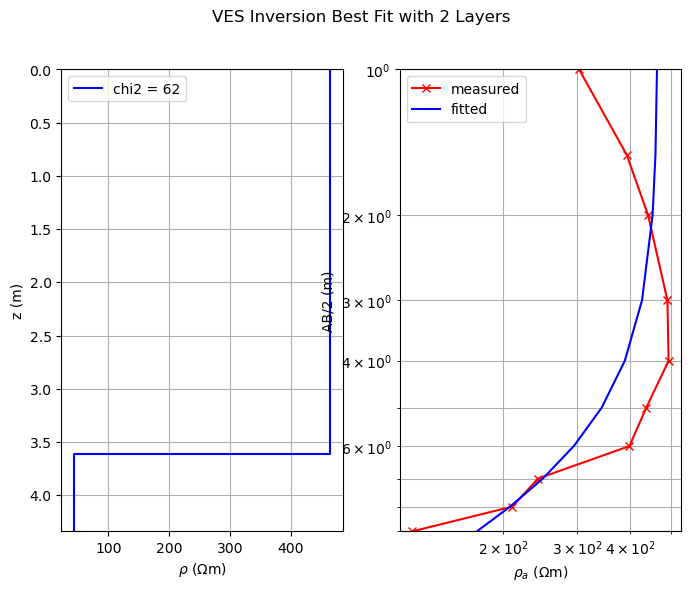

,Resistivity (Ohm*m),Conductivity (S/m),Thickness (m)
0,464.803315,0.002151,3.615069
1,43.664109,0.022902,inf


In [86]:
# Okay, repeating this for the cows dataset using THE SAME lead resistance (can I do this?? Lets find out)
df2 = dcowsns
ab2 = df2["ab2"][:-2]
mn2 = np.zeros(ab2.shape) + 0.5
rhoa = ((df2["r"] - popt[1])*k)[:-3]

nlay = 2

model, chi2 = invert(nlay, ab2, mn2, 2000, rhoa, 0.9)
res, thk = model[nlay-1:nlay*2-1], list(model[0:nlay-1])
thk.append(np.inf)
layers = pd.DataFrame({"Resistivity (Ohm*m)": res, "Conductivity (S/m)": 1/res, "Thickness (m)": thk})
layers

In [87]:
df2 = dcowsns
ab2 = df2["ab2"][:-4]
mn2 = np.zeros(ab2.shape) + 0.5
rhoa = (df2["r"][:-3] - popt[1])*k[:-4]
rhoa

0    302.699929
1    392.509581
2    441.431154
3    490.673107
4    493.803329
5    436.967396
6    398.689418
7    241.956684
8    210.258332
dtype: float64

In [79]:
ab2 = df2["ab2"][:-2]
mn2 = np.zeros(ab2.shape) + 0.5
rhoa = ((df2["r"] - popt[1])*k)[:-3]
ab2, mn2, rhoa

(0    1.0
 1    1.5
 2    2.0
 3    3.0
 4    4.0
 5    5.0
 6    6.0
 7    7.0
 8    8.0
 9    9.0
 Name: ab2, dtype: float64,
 array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]),
 0    302.699929
 1    392.509581
 2    441.431154
 3    490.673107
 4    493.803329
 5    436.967396
 6    398.689418
 7    241.956684
 8    210.258332
 9    121.727565
 dtype: float64)

In [72]:
df2["r"], k

(0     128.40
 1      62.40
 2      37.40
 3      17.78
 4       9.91
 5       5.55
 6       3.48
 7       1.51
 8       0.98
 9       0.41
 10      0.00
 11      0.00
 Name: r, dtype: float64,
 0       2.356194
 1       6.283185
 2      11.780972
 3      27.488936
 4      49.480084
 5      77.754418
 6     112.311937
 7     153.152642
 8     200.276532
 9     253.683607
 10    313.373867
 11    379.347313
 12    451.603944
 dtype: float64)